In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits
from gprot.aigrain import AigrainTruths

resultsdir = '../results_bestchunks'
df = summarize_fits(resultsdir, truths='aigrain')
df = df.join(AigrainTruths().df)

df_acf_all = pd.read_table('../acf_all.txt', delim_whitespace=True)
df_acf_all.index = df_acf_all['star']
# df_acf = df_acf.sort_values(['star', 'quality'], ascending=[True, False]).groupby('star').first()
# df_acf = df_acf.join(AigrainTruths().df)
# df_acf['P_MEAN'] = (df_acf.P_MIN + df_acf.P_MAX)/2.

In [86]:
def select_acf_prots(df):
    """Chooses the best period out of candidate periods for each star
    """
    new_df = pd.DataFrame(columns=df.columns, index=np.unique(df.index))

    for ix in np.unique(df.index):
        debug = False
        
        subdf = df.ix[ix]
        qbest = 0
        taurat_best = 0
        for i in range(len(subdf)):
            q = subdf.quality.iloc[i]
            tau = subdf.tau.iloc[i]
            prot = subdf.prot.iloc[i]
            taurat = tau/prot
            if debug:
                print(i, q, taurat)
            if q/qbest > taurat_best/taurat: 
                if taurat > taurat_best:
                    qbest = q
                    taurat_best = taurat
                    ibest = i
                    if debug:
                        print('best: {}, {}, {}'.format(ibest, qbest, taurat_best))
        new_df.ix[ix] = subdf.iloc[ibest]
    
    new_df.prot = new_df.prot.astype(float)
    new_df.height = new_df.height.astype(float)
    new_df.tau = new_df.tau.astype(float)
    new_df.quality = new_df.quality.astype(float)
    return new_df

df_acf = select_acf_prots(df_acf_all)
df_acf = df_acf.join(AigrainTruths().df)
df_acf['P_MEAN'] = (df_acf.P_MIN + df_acf.P_MAX)/2.
df_acf['good'] = np.abs((df_acf.prot - df_acf.P_MEAN) / df_acf.P_MEAN) < 0.2

/Users/tdm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars


In [87]:
df_acf_all = df_acf_all.join(AigrainTruths().df)
df_acf_all['P_MEAN'] = (df_acf_all['P_MIN'] + df_acf_all['P_MAX'])/2.
df_acf_all['good'] = np.abs((df_acf_all.prot - df_acf_all.P_MEAN) / df_acf_all.P_MEAN) < 0.2

In [88]:
cols = ['pmax', 'prot', 'height', 'tau', 'quality', 'P_MEAN','TAU', 'good']
df_acf_all[cols].ix[558]

,pmax,prot,height,tau,quality,P_MEAN,TAU,good
558,5,1.697,0.257,0.749,82.61,1.692529,1.72,True
558,10,1.615,0.194,0.336,38.09,1.692529,1.72,True
558,20,16.270,0.264,10.945,68.19,1.692529,1.72,False
558,40,16.658,0.233,11.261,218.16,1.692529,1.72,False
558,60,16.679,0.208,11.536,252.04,1.692529,1.72,False
558,100,16.393,0.171,12.968,386.73,1.692529,1.72,False


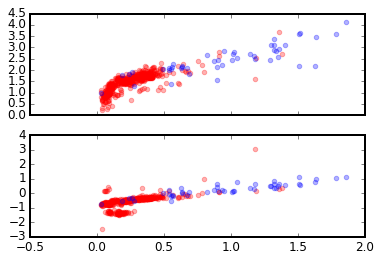

In [92]:
good5 = df_acf_all.query('pmax==5 and good')
nogood5 = df_acf_all.query('pmax==5 and not good and height > 0')

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.scatter(nogood5.height, np.log10(nogood5.quality), label='not good', color='r', alpha=0.3);
ax1.scatter(good5.height, np.log10(good5.quality), label='good', color='b', alpha=0.3) 
ax2.scatter(nogood5.height, np.log10(nogood5.tau/nogood5.prot), label='not good', color='r', alpha=0.3);
ax2.scatter(good5.height, np.log10(good5.tau/good5.prot), label='good', color='b', alpha=0.3) 
# plt.legend();

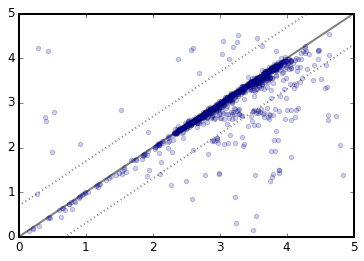

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

# q = 'tau > 0.5*prot and DELTA_OMEGA==0'
q = 'DELTA_OMEGA==0'
q = 'DELTA_OMEGA > -1'

fig, ax = plt.subplots(1,1)
points = ax.scatter(np.log(df_acf.query(q)['P_MEAN']), np.log(df_acf.query(q).prot), 
                    alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.plot(range(6), np.arange(6) + np.log(2), ls=':', c='k', alpha=0.5)
ax.plot(range(6), np.arange(6) - np.log(2), ls=':', c='k', alpha=0.5)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = plugins.PointLabelTooltip(points, labels=['{}: {:.2f} ({:.2f})'.format(i, df_acf.ix[i, 'P_MEAN'],
                                                                                 df_acf.ix[i, 'prot'])
                                                    for i in df_acf.query(q).index])
plugins.connect(fig, tooltip)

In [99]:
# Features: pmax, prot, height, tau, quality
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm

Classifier = RandomForestClassifier
kwargs = dict(n_estimators=20)
# Classifier = svm.SVC
# kwargs = dict(C=10.0, cache_size=100, class_weight=None, coef0=0.0,
#     decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=True, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

def transform_X(Xin):
    X = Xin.copy()
    X['pmax'] /= Xin['pmax'].max()
    X['prot'] /= Xin['prot'].max()
    X['height'] /= Xin['height'].max()
    X['taurat'] /= Xin['taurat'].quantile(0.9)
    X['quality'] /= Xin['quality'].quantile(0.9)
    for col in X.columns:
        if col not in ['pmax', 'prot', 'height', 'taurat', 'quality']:
            del X[col]
    return X

df_ok = df_acf_all[['pmax', 'prot', 'height', 'tau', 'quality', 'good', 'P_MEAN']].dropna()
X = df_ok[['pmax', 'prot', 'height', 'quality']]
X['taurat'] = df_ok['tau']/df_ok['prot']
X = transform_X(X)
y = df_ok['good']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

clf = Classifier(**kwargs)
clf = clf.fit(X_train, y_train)

/Users/tdm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [100]:
clf.score(X_test, y_test)

0.89015691868758917

In [101]:
df_acf_all['taurat'] = df_acf_all['tau'] / df_acf_all['prot']
X_all = transform_X(df_acf_all.dropna())
ypred = clf.predict(X_all)

In [116]:
ok = np.logical_not(df_acf_all.isnull().any(axis=1))

In [127]:
good_pred = np.zeros(len(df_acf_all), dtype=bool)
good_pred[np.where(ok)] = ypred
df_acf_all['good_pred'] = good_pred

In [135]:
df_acf_all.ix[70, cols + ['good_pred']]

,pmax,prot,height,tau,quality,P_MEAN,TAU,good,good_pred
70,5,NaN,-inf,NaN,NaN,43.263914,2.11,False,False
70,10,6.827,0.731000,8.012,507.62,43.263914,2.11,False,True
70,20,6.909,0.411000,5.986,140.91,43.263914,2.11,False,False
70,40,6.745,0.298000,2.514,24.49,43.263914,2.11,False,True
70,60,6.684,0.215000,1.121,8.14,43.263914,2.11,False,False
70,100,6.439,0.228000,0.830,9.16,43.263914,2.11,False,False


In [131]:
df_acf_all.query('good_pred != good')[cols + ['good_pred']]

,pmax,prot,height,tau,quality,P_MEAN,TAU,good,good_pred
51,20,9.402,0.256,11.724,20.05,50.050000,5.31,False,True
51,100,55.964,0.425,36.070,83.90,50.050000,5.31,True,False
67,10,1.206,0.157,0.238,40.19,1.336636,7.25,True,False
70,10,6.827,0.731,8.012,507.62,43.263914,2.11,False,True
70,40,6.745,0.298,2.514,24.49,43.263914,2.11,False,True
72,20,13.306,0.713,9.767,484.50,32.314141,3.00,False,True
72,40,13.736,0.122,4.528,7.02,32.314141,3.00,False,True
79,20,16.515,0.797,21.988,442.08,23.895332,6.82,False,True
87,40,19.070,0.147,5.021,15.57,16.047648,5.16,True,False
93,10,4.292,0.408,2.828,192.05,4.298977,1.84,True,False


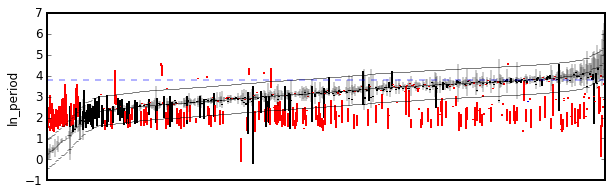

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

inds = df.index[np.argsort(df.aigrain_p_mean)]
fig, ax = plt.subplots(1, 1, figsize=(10,3))
lines = []
labels = []
colors = []
ln2 = np.log(2)
di = 0.5
bad_shortP = []
bad_longP = []
highlight = [466]
for i,ix in enumerate(inds):
    ymin, ymax = df.ix[ix, ['aigrain_p_min', 'aigrain_p_max']]
    ymean = (ymin + ymax)/2.
    ax.plot([i,i], [ymin, ymax], color='k', alpha=0.2)
    ax.plot([i-di, i+di], [ymean, ymean], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean-ln2, ymean-ln2], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean+ln2, ymean+ln2], color='k', lw=1, alpha=0.3)
#     tau, peq = df.ix[ix, ['TAU', 'PEQ']]
#     y_tau = np.log(tau*peq)
#     ax.plot([i-0.5, i+1.5], [y_tau, y_tau], color='k', lw=1)
    
    
    ylo, yhi = df.ix[ix, ['ln_period_16', 'ln_period_84']]
    if ix in highlight:
        color = 'b'
    elif (yhi < ymin) or (ylo > ymax):
        color='r'
        if yhi < ymin:
            bad_longP.append(ix)
        else:
            bad_shortP.append(ix)
    else:
        color='k'
    lines.append(([i,ylo], [i,yhi]))
    colors.append(color)
    label = '{}: AMP={:.2e}'.format(ix, df.ix[ix, 'AMP'])
    labels.append(label)

collection = LineCollection(lines, colors=colors, linewidths=2)
ax.add_collection(collection)
ax.set_xlim((-0.5, i+0.5))
ax.set_xticks([]);
ax.set_ylabel('ln_period');
ax.plot([-0.5, i+0.5], [np.log(45), np.log(45)], ls='--', color='b', alpha=0.3);

tooltip = mpld3.plugins.PointLabelTooltip(collection, labels=labels)
plugins.connect(fig, tooltip)

In [9]:
np.savetxt('bad_shortP.list', bad_shortP, fmt='%i')
np.savetxt('bad_longP.list', bad_longP, fmt='%i')

In [11]:
bad_longP

[779,
 336,
 376,
 542,
 301,
 640,
 497,
 736,
 347,
 552,
 281,
 487,
 271,
 397,
 387,
 536,
 458,
 47,
 112,
 268,
 108,
 443,
 94,
 503,
 166,
 646,
 540,
 689,
 28,
 64,
 816,
 451,
 732,
 60,
 454,
 245,
 440,
 406,
 2,
 413,
 394,
 143,
 140,
 868,
 377,
 228,
 766,
 68,
 110,
 412,
 308,
 695,
 104,
 25,
 313,
 481,
 583,
 77,
 231,
 470,
 426,
 76,
 191,
 33,
 269,
 423,
 556,
 782,
 936,
 655,
 967,
 482,
 329,
 157,
 433,
 553,
 768,
 647,
 430,
 743,
 710,
 221,
 551,
 256,
 359,
 460,
 146,
 246,
 128,
 11,
 591,
 17,
 713,
 203,
 307,
 389,
 135,
 811,
 368,
 884,
 333,
 576,
 267,
 300,
 167,
 342,
 475,
 139,
 130,
 335,
 704,
 653,
 761,
 260,
 450,
 343,
 98,
 7,
 701,
 499,
 31,
 522,
 199,
 349,
 72,
 80,
 26,
 296,
 164,
 48,
 122,
 994,
 9,
 326,
 456,
 152,
 40,
 207,
 153,
 249,
 853,
 111,
 792,
 999,
 69,
 201,
 289,
 882,
 447,
 126,
 997,
 468,
 894,
 669,
 530,
 520,
 694,
 217,
 383,
 120,
 192,
 119,
 407,
 318,
 253,
 115,
 399,
 145,
 176,
 608,
 29,
 

In [6]:
len(bad)

352

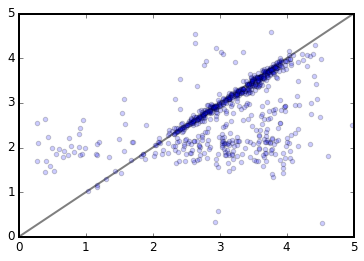

In [5]:
fig, ax = plt.subplots(1,1)
points = ax.scatter(df.aigrain_p_mean, df.ln_period_50, alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = mpld3.plugins.PointLabelTooltip(points, labels=[i for i in df.index])
plugins.connect(fig, tooltip)

In [28]:
i = 279
print(np.log(truth.ix[i, ['P_MIN','P_MAX']]))
print(df.ix[i, ['ln_period_16', 'ln_period_84']])

P_MIN    3.905804
P_MAX    3.905804
Name: 279, dtype: float64
ln_period_16    2.601855
ln_period_84    2.651217
Name: 279, dtype: float64


In [30]:
np.exp(3.906)

49.699754825406366

In [31]:
from gprot.lc import qtr_times
qtr_times

,tstart,tstop
q,,
1,131.511880,164.983257
2,169.518900,258.466998
3,260.223736,349.494411
4,352.376612,442.202053
5,443.489554,538.161241
6,539.449771,629.295934
7,630.174122,719.547036
8,735.362357,802.343677
9,808.515159,905.926044
